### Using Machine Learning to Predict Protest or Riot Events in Nigeria

In our last post we analyzed a conflict data set in Power BI and came to the conclusion that when our colleague travels to Abuja she should be mindful of protesters and riots. We generated these insights based on the ACLED data set which can be found online here. https://www.acleddata.com/

When briefing our colleague about the data generated insights we next learn that she often will hear about security events near her project and the team often wonders who’s responsible.  She comes back to us and says “I heard that data scientists can predict the future. Can you accurately predict who's responsible for the event before we are officially notified? This is the type of information that I could really use when I'm in the field.” She tells us that she usually knows where the event takes place, but doesn't always know if protestors or rioters are responsible. We let her know that such predictions are pretty difficult and explain similar challenges data scientists have had with predictive policing. But given that we've got a good data set and great data science chops, let's go back to the data and see if we can assist our colleague. 

To start with let's download the full Nigeria conflict data set. Since we are going to be building a machine learning model, we want the largest dataset possible. We'll next turn to a trusty machine learning toolkit called ski-kit learn. 

First load your libraries 


In [111]:
import pandas as pd
%matplotlib inline
import os, sys
import itertools
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

#### Import the data

We will import the data set and drop unnecessary columns.  Shuffling a data set is always good practice before running it through a model.  There could be longitudinal patterns in there that could cause the model not to generalize well with future data.  

In [112]:
df = pd.read_csv('Nigeria_Large.csv')

# drop columns we don't need 
df = df.drop(['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'time_precision', 'location', 'fatalities',
              'event_type', 'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2', 
              'interaction', 'region', 'country', 'admin2', 'admin3', 'geo_precision', 'source', 
             'source_scale', 'notes', 'timestamp', 'iso3'], axis=1)


# shuffle dataframe
df = shuffle(df)

# look at the first few rows. 
df.head()

,event_date,year,actor1,admin1,latitude,longitude
5508,9-Jul-15,2015,Rioters (Nigeria),Lagos,6.4531,3.3958
360,17-Sep-18,2018,Giwa Communal Militia (Nigeria),Kaduna,11.0538,7.1958
8930,14-Mar-13,2013,Police Forces of Nigeria (1999-2015),Borno,11.1036,13.7130
765,24-Jun-18,2018,Unidentified Armed Group (Nigeria),Imo,5.7963,7.0907
11099,21-Dec-08,2008,Unidentified Armed Group (Nigeria),Ogun,7.1500,3.3500


### Introduction to Feature Engineering 

Now we're going to introduce you to an important concept called feature engineering.  

Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work better. If feature engineering is done correctly, it increases the predictive power of machine learning  by creating features (new columns) from raw data that help facilitate the machine learning process. Feature Engineering is an art and is probably one aspect of machine learning that will remain "human" for the foresable future.  

We are going to start with a simple example by using the day of the week column.  We will first extract the day of the week and move on to something more complex like seasons.  

In [113]:
import datetime

# change to datetime object 
df['event_date'] = pd.to_datetime(df['event_date'])

# convert date to day of the week
df['day_of_week'] = df['event_date'].dt.day_name()

# now, let's extract the month and the year in one line 
df['year'], df['month'] = df['event_date'].dt.year, df['event_date'].dt.month


# now let's do something more advanced and extract the season

def season_of_date(date):
    # Assuming df has a date column of type `datetime`
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'


df['season'] = df.event_date.map(season_of_date)

df.head()

,event_date,year,actor1,admin1,latitude,longitude,day_of_week,month,season
5508,2015-07-09,2015,Rioters (Nigeria),Lagos,6.4531,3.3958,Thursday,7,summer
360,2018-09-17,2018,Giwa Communal Militia (Nigeria),Kaduna,11.0538,7.1958,Monday,9,summer
8930,2013-03-14,2013,Police Forces of Nigeria (1999-2015),Borno,11.1036,13.7130,Thursday,3,winter
765,2018-06-24,2018,Unidentified Armed Group (Nigeria),Imo,5.7963,7.0907,Sunday,6,summer
11099,2008-12-21,2008,Unidentified Armed Group (Nigeria),Ogun,7.1500,3.3500,Sunday,12,winter


Now let's try something even more complex.  We're going to add a distance measure to our data as an additional feature.  We'll go ahead and add the lat and lon coordinates for Abuja and calculate the haversine distance from that Abuja to all other points in our data set.  This distance measure will be calculated and returned in Kilometers and by doing this we get a boost in performance of just a few minor percentage points in our model.  Doing this over and over is what feature engineering is all about.   

In [114]:
# First we add the Lat and Long Points for Abuja to our data 
df['Lat2'] = 9.072264 
df['Lon2'] = 7.491302

# Now - we'll use this function to calculate the haversine distance from point to point.  
# This ends up being a more manual implementation of what we did in our last blog calling a similar function in R

# import the key libraries 
from numpy import radians, cos, sin, arcsin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """

    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1.values)
    lat1 = np.radians(lat1.values)
    lon2 = np.radians(lon2.values)
    lat2 = np.radians(lat2.values)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),  
                          np.multiply(np.cos(lat1), 
                                      np.multiply(np.cos(lat2), 
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))
    c = np.multiply(2, np.arcsin(np.sqrt(a)))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles

    return c*r


df['distanceKM'] = haversine(df.longitude, df.latitude, df.Lon2, df.Lat2)

# Let's take a look at the results and our new column - distanceKM
df.head()

,event_date,year,actor1,admin1,latitude,longitude,day_of_week,month,season,Lat2,Lon2,distanceKM
5508,2015-07-09,2015,Rioters (Nigeria),Lagos,6.4531,3.3958,Thursday,7,summer,9.072264,7.491302,537.015000
360,2018-09-17,2018,Giwa Communal Militia (Nigeria),Kaduna,11.0538,7.1958,Monday,9,summer,9.072264,7.491302,222.699069
8930,2013-03-14,2013,Police Forces of Nigeria (1999-2015),Borno,11.1036,13.7130,Thursday,3,winter,9.072264,7.491302,717.554359
765,2018-06-24,2018,Unidentified Armed Group (Nigeria),Imo,5.7963,7.0907,Sunday,6,summer,9.072264,7.491302,366.938038
11099,2008-12-21,2008,Unidentified Armed Group (Nigeria),Ogun,7.1500,3.3500,Sunday,12,winter,9.072264,7.491302,503.483984


#### In this exercise we are going to predict who's responsible 

This information is found in the Actor column and will be our predictive variable. Let's look at that column in more detail. We notice in the full data set we have Protestors and Rioters. These are the "actors' our colleague is most interested in predicting based on the location of the event. 

In [115]:
# let's look at the top value counts for each categorical variable
pd.value_counts(df['actor1'].values, sort=True).head(10)

Protesters (Nigeria)                                        3082
Unidentified Armed Group (Nigeria)                          2139
Rioters (Nigeria)                                           1298
Fulani Ethnic Militia (Nigeria)                              978
Military Forces of Nigeria (2015-)                           954
Boko Haram - Jamatu Ahli is-Sunnah lid-Dawatai wal-Jihad     882
Military Forces of Nigeria (1999-2015)                       729
Boko Haram - Wilayat Gharb Ifriqiyyah                        425
Police Forces of Nigeria (1999-2015)                         419
Vigilante Militia (Nigeria)                                  253
dtype: int64

Now let's subset our data based on the most common "actors" responsible for conflict events 

In [116]:
value_list = ['Protesters (Nigeria)', 
              'Military Forces of Nigeria (2015-)', 
              'Fulani Ethnic Militia (Nigeria)',
             'Rioters (Nigeria)', 
              'Boko Haram - Jamatu Ahli is-Sunnah lid-Dawatai wal-Jihad', 
              'Military Forces of Nigeria (1999-2015)',
             'Boko Haram - Wilayat Gharb Ifriqiyyah', 
             'Police Forces of Nigeria (1999-2015)', 
             'Vigilante Militia (Nigeria)']



#Grab DataFrame rows where column has certain values
df = df[df.actor1.isin(value_list)]

pd.value_counts(df['actor1'].values, sort=True)

Protesters (Nigeria)                                        3082
Rioters (Nigeria)                                           1298
Fulani Ethnic Militia (Nigeria)                              978
Military Forces of Nigeria (2015-)                           954
Boko Haram - Jamatu Ahli is-Sunnah lid-Dawatai wal-Jihad     882
Military Forces of Nigeria (1999-2015)                       729
Boko Haram - Wilayat Gharb Ifriqiyyah                        425
Police Forces of Nigeria (1999-2015)                         419
Vigilante Militia (Nigeria)                                  253
dtype: int64

#### Data processing 

Now we'll process our data a bit to clean up and combine some of the 'actor' values.  

In [117]:
def cleaning(df):
    df = df.replace('Military Forces of Nigeria (1999-2015)', 'Military Forces of Nigeria')
    df = df.replace('Military Forces of Nigeria (2015-)', 'Military Forces of Nigeria')
    df = df.replace('Protesters (Nigeria)', 'Protesters/Rioters')
    df = df.replace('Rioters (Nigeria)', 'Protesters/Rioters')
    df = df.replace('Boko Haram - Jamatu Ahli is-Sunnah lid-Dawatai wal-Jihad', 'Boko Haram')
    df = df.replace('Boko Haram - Wilayat Gharb Ifriqiyyah', 'Boko Haram')

    return df
    

df = cleaning(df)    
pd.value_counts(df['actor1'].values, sort=True)    

Protesters/Rioters                      4380
Military Forces of Nigeria              1683
Boko Haram                              1307
Fulani Ethnic Militia (Nigeria)          978
Police Forces of Nigeria (1999-2015)     419
Vigilante Militia (Nigeria)              253
dtype: int64

In [118]:
df['Predictor'] = np.where(df['actor1']=='Protesters/Rioters', 1, 0) # one represents a protest event and zero is other

df.head()

,event_date,year,actor1,admin1,latitude,longitude,day_of_week,month,season,Lat2,Lon2,distanceKM,Predictor
5508,2015-07-09,2015,Protesters/Rioters,Lagos,6.4531,3.3958,Thursday,7,summer,9.072264,7.491302,537.015000,1
8930,2013-03-14,2013,Police Forces of Nigeria (1999-2015),Borno,11.1036,13.7130,Thursday,3,winter,9.072264,7.491302,717.554359,0
7333,2014-06-24,2014,Fulani Ethnic Militia (Nigeria),Kaduna,9.2333,8.5167,Tuesday,6,summer,9.072264,7.491302,113.982563,0
1750,2018-01-11,2018,Protesters/Rioters,Kaduna,10.5222,7.4383,Thursday,1,winter,9.072264,7.491302,161.330087,1
3198,2017-02-16,2017,Protesters/Rioters,Benue,7.8155,8.8604,Thursday,2,winter,9.072264,7.491302,205.436593,1


Machine learning models don't work so well when we have empty column values. Here we can decide if we want to impute new values or drop them. If you impute values we can often use the mean, median or mode depending on the situation. Here we decide to keep it simple and drop any columns with NAs.

In [119]:
dataset = df.dropna(how='any') #to drop if any value in the row has a nan
dataset = dataset.reset_index(drop=True) # reset index

print(dataset.isnull().sum()) # view nan counts in columms.  

event_date     0
year           0
actor1         0
admin1         0
latitude       0
longitude      0
day_of_week    0
month          0
season         0
Lat2           0
Lon2           0
distanceKM     0
Predictor      0
dtype: int64


Before we are ready to create a machine learning model, we need to transform our data a little bit more by creating dummy variables.  

In [120]:
# use this code if you want to save a cleaned up feature eng dataset 

#dataset = dataset.reset_index(drop=True) # reset index
#dataset.to_csv('Nigeria_Clean.csv', sep=',', encoding='utf-8')

In [121]:
# drop all the columns we don't need.  The Lat and Lon coords for Abjua don't help the model at all so we drop those too.
df = dataset.drop(['event_date', 'actor1', 'Lat2', 'Lon2', 'Predictor'], axis=1) 

df = df.reset_index(drop=True) # reset index

df.head()

,year,admin1,latitude,longitude,day_of_week,month,season,distanceKM
0,2015,Lagos,6.4531,3.3958,Thursday,7,summer,537.015000
1,2013,Borno,11.1036,13.7130,Thursday,3,winter,717.554359
2,2014,Kaduna,9.2333,8.5167,Tuesday,6,summer,113.982563
3,2018,Kaduna,10.5222,7.4383,Thursday,1,winter,161.330087
4,2017,Benue,7.8155,8.8604,Thursday,2,winter,205.436593


Before we are ready for creating a machine learning model, we need to transform our data a little bit more by creating dummy variables.  

In [122]:
# encode the data using pandas get_dummies
features = pd.get_dummies(df)
# Display the first 5 rows to see how the data has changed. Note how we have wide data now.  
features.iloc[:,5:].head(5)

,admin1_Abia,admin1_Adamawa,admin1_Akwa Ibom,admin1_Anambra,admin1_Bauchi,admin1_Bayelsa,admin1_Benue,admin1_Borno,admin1_Cross River,admin1_Delta,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,season_autumn,season_spring,season_summer,season_winter
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


Before we can run this data through a machine learning algorithum, we need to take a few important steps.  

First let's make sure our classes are balanced.  Given that we are dealing with a two class or bianary problem (predicting protests/riots or other events) we can balance the classes in a relatively straight forward way.  

We will use this function below to balance the classes and then make sure our data is stored in the format of an array.  We'll use python numpy arrays as they work great with sci-kit learn. 

In [123]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

X = np.array(features)
y = np.array(dataset.Predictor) #iloc[:,1]) # actor


X, y = balanced_subsample(X, y)

# print(X)
print(X.shape)
print(y.shape)

(8760, 53)
(8760,)


Check to see if our classes were actually balanced.  We'll look at the ratio and hope to see a 50% split

In [124]:
num_protests = np.sum(y==1) # find out total number of protests vs. other events 
print('ratio:', num_protests, '/', len(X), '=', num_protests / len(X))

ratio: 4380 / 8760 = 0.5


Before we run our model we need to split the data in training and testing sets.  This will help us evaluate how well the model performs on data it hasn't seen before.  Utimately with any machine learning model we'll need to feed it new data to make predictions.  Creating a testing set and evaluating your model is a critical step to building any machine learning model.  

In [125]:
# X = np.array(features)
# y = np.array(dataset.Predictor) #iloc[:,1]) # actor

# We can of course run a train-test split on the separated data as well
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# show rows and columns.  Make sure the X and y row counts are the same. 
print(X_train.shape)
print(y_train.shape)

(7008, 53)
(7008,)


LR: 0.794292 (0.039461)
LDA: 0.790868 (0.039143)
KNN: 0.804224 (0.033838)
CART: 0.795091 (0.020518)
NB: 0.812100 (0.014495)
SVM: 0.808219 (0.049533)
RFC: 0.822717 (0.035663)


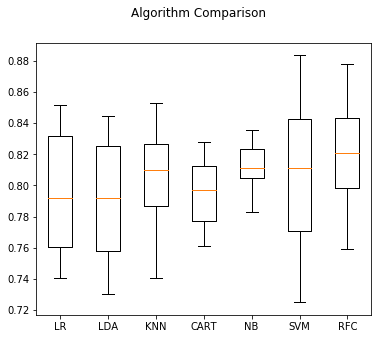

In [126]:
def ClassifierComparison(X, y):
    # Compare Algorithms
    seed = 7
    # prepare models
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    models.append(('RFC', RandomForestClassifier(n_estimators = 100, n_jobs=2)))

    # evaluate each model 
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    # boxplot algorithm comparison
    fig = plt.figure(figsize = (6,5))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

# run the function on our data set
ClassifierComparison(X, y)    

### The Random Forest Classifer works best 

Now let's see which hyperparameters work best to train our model. 

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#from sklearn import cross_validation
from sklearn import feature_selection, pipeline, preprocessing, linear_model #, grid_search

rf_model = RandomForestClassifier()
top_feat = feature_selection.SelectKBest()

pipe = Pipeline(steps=[('feat', top_feat), ('rf_model', rf_model)])

n_components = [4, 8, 16]
K = [2, 4, 10, 15, 20, 30]
param_grid = [
    {
        'feat__k': K,
        'rf_model__max_features' : ['auto', 'sqrt', 'log2'],
        'rf_model__max_depth': [None, 15, 10, 5, 1],
        'rf_model__n_estimators':[25, 50, 100]
    },
]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
#estimator = GridSearchCV(pipe, dict(pca__n_components=n_components, logistic__C=Cs), cv=3)
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)

grid.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('feat', SelectKBest(k=10, score_func=<function f_classif at 0x000001CF2DB077B8>)), ('rf_model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurit...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'feat__k': [2, 4, 10, 15, 20, 30], 'rf_model__max_features': ['auto', 'sqrt', 'log2'], 'rf_model__max_depth': [None, 15, 10, 5, 1], 'rf_model__n_estimators': [25, 50, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [128]:
# the results below show the features selected.  
print("This is the best score:", grid.best_score_)

# the results below show the hyperparameters.  
print("These are the best hyperparameters to train our Random Forest Model on:", grid.best_params_)

This is the best score: 0.8407534246575342
These are the best hyperparameters to train our Random Forest Model on: {'feat__k': 10, 'rf_model__max_depth': 10, 'rf_model__max_features': 'log2', 'rf_model__n_estimators': 25}


Now that we know which hyperparameters will return the best results, let's set those and run a cross validation to view how the model performs over smaller subsets of our data set.  

In [129]:
clf = RandomForestClassifier(n_estimators = 100, max_depth=10, n_jobs=3, max_features='auto', random_state=157)

# run cross validation 
cross_val_score(clf, X, y, cv=10)

array([0.83105023, 0.82191781, 0.86415525, 0.85616438, 0.82191781,
       0.85045662, 0.84703196, 0.85273973, 0.83789954, 0.82990868])

#### Time for some Predictions 

Now let's make some predictions on our data and evaluate how well the model is doing. Here we run the test data through the trained model and use the predict function. We store our predictions in the y_pred object. We then compare the predictions (y_pred) to the actuals (y_test) to see which predictions it got right and which predictions it got wrong.   We will view the results by calling a classification report, accuracy score, and viewing a confusion matrix. 

In [130]:
# make predictions with test data 

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# verify input and output shape are appropriate
print("Input vs. output shape:")
print(X_test.shape, y_pred.shape)

#print classification report 
print(classification_report(y_test, y_pred))

print("accuracy score: ", accuracy_score(y_test, y_pred))

# show confusion matrix in the raw 
print(confusion_matrix(y_test, y_pred))

Input vs. output shape:
(1752, 53) (1752,)
              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83       863
         1.0       0.82      0.90      0.85       889

   micro avg       0.84      0.84      0.84      1752
   macro avg       0.85      0.84      0.84      1752
weighted avg       0.85      0.84      0.84      1752

accuracy score:  0.8441780821917808
[[683 180]
 [ 93 796]]


Now plot the confusion matrix, rather than viewing it raw.  Here we want to see the colors pop diagonally from left to right – top to bottom.  These are the instances where the model was accurate.  True Positives.  The numbers in black show False Positives where the model got it wrong.  We can visually notice that it predicts conflict events where Protestors/Rioters are responsible better than it does Boko Haram.  

Text(0.5,15,'Predicted label')

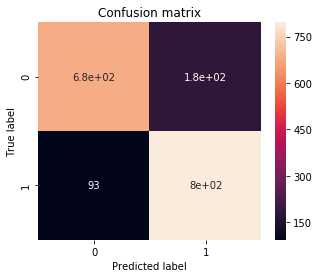

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize = (5,4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Great - now let's look at our results.  We look at our results and notice we can predict protests/riots about 85 percent of the time. Our colleague is going to be happy when we share these results with her.  But wait...just because we are able to predict who's responsible we need to ask some pretty important questions about what we're doing here.  We can pack anything into a machine learning model, but does that mean it will actually work and perform when we need it most.  I mean even Google or Amazon cannot always predict my searches or tastes acturately.  What type of caveats might we need to convey and what other steps might we consider to improve this model or make it meaninful to our colleague.  

We'll pick this apart in more detail in our next blog.  For now, you've learned some of the most basic machine learning steps in python. We don't always get good results like this when running an initial model - so for now - give yourself a pat on the back before we scrutinize this a bit more.  

In [132]:
# print the important features.

# notice all the features we added.  Many of these additional features helped our model. 

important_features = pd.Series(data=clf.feature_importances_,index=features.columns)
important_features.sort_values(ascending=False)

latitude                            0.250258
longitude                           0.244594
distanceKM                          0.156997
admin1_Borno                        0.096722
year                                0.056981
admin1_Federal Capital Territory    0.023999
admin1_Benue                        0.018141
month                               0.018016
admin1_Lagos                        0.016285
admin1_Adamawa                      0.008677
day_of_week_Sunday                  0.008438
admin1_Taraba                       0.008401
admin1_Yobe                         0.007980
admin1_Plateau                      0.007248
day_of_week_Saturday                0.004992
day_of_week_Monday                  0.004432
admin1_Kaduna                       0.004135
day_of_week_Friday                  0.003952
season_summer                       0.003927
season_autumn                       0.003770
season_spring                       0.003635
season_winter                       0.003292
admin1_Nas

In [133]:
#probabilities
probs = clf.predict_proba(X_test)
